In [68]:
#https://www.kaggle.com/nicapotato/keras-timeseries-multi-step-multi-output

import pandas as pd
import numpy as np
from numpy import hstack
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV
import seaborn as sns
from tensorflow import keras
from keras.models import Input, Model, Sequential
from keras.layers import Dense, Dropout, LSTM, Concatenate, SimpleRNN, Masking, Flatten
from keras import losses
from keras.callbacks import EarlyStopping
from keras.initializers import RandomNormal
import tensorflow as tf

In [59]:
def create_time_steps(length):
    return list(range(-length, 0))
def multivariate_multioutput_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data)[:,:,:,np.newaxis,np.newaxis], np.array(labels)[:,:,:,np.newaxis,np.newaxis]

def multi_step_output_plot(history, true_future, prediction):
    plt.figure(figsize=(18, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)
    
    for i, (var, c) in enumerate(zip(features.columns[:2], ['b','r'])):
        plt.plot(num_in, np.array(history[:, i]), c, label=var)
        plt.plot(np.arange(num_out)/STEP, np.array(true_future[:,i]), c+'o', markersize=5, alpha=0.5,
               label=f"True {var.title()}")
        if prediction.any():
            plt.plot(np.arange(num_out)/STEP, np.array(prediction[:,i]), '*', markersize=5, alpha=0.5,
                     label=f"Predicted {var.title()}")
    
    plt.legend(loc='upper left')
    plt.show()

In [84]:
df = pd.read_csv("../data/data_processed.csv")
df['date'] = pd.to_datetime(df['date'], format='%Y/%m/%d %H:%M')
df['production_usage'] = df['production_usage'].fillna(df['production_usage'].median())

df['fve'] = df['fve'] * 0.03
df['mve'] = df['mve'] * 0.07
df['wpg'] = df['wpg'] * 0.07

df['production_usage'] = df['fve'] + df['mve'] + df['wpg'] 

In [74]:
df[['production_usage', 'consumption_usage']]

,production_usage,consumption_usage
0,167.8992,76.404
1,181.7160,72.212
2,180.2994,70.992
3,179.3502,70.872
4,181.6752,80.540
...,...,...
35035,61.3482,43.992
35036,60.8886,45.552
35037,60.5688,45.240
35038,60.6756,44.304


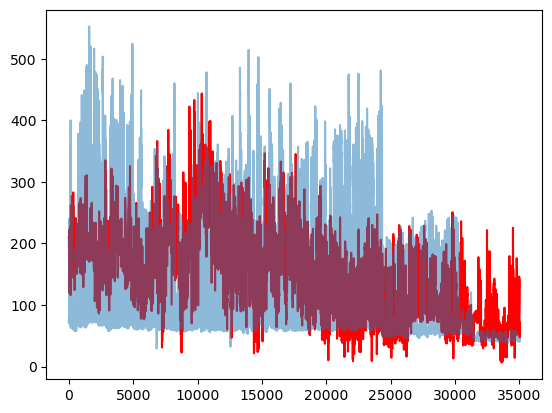

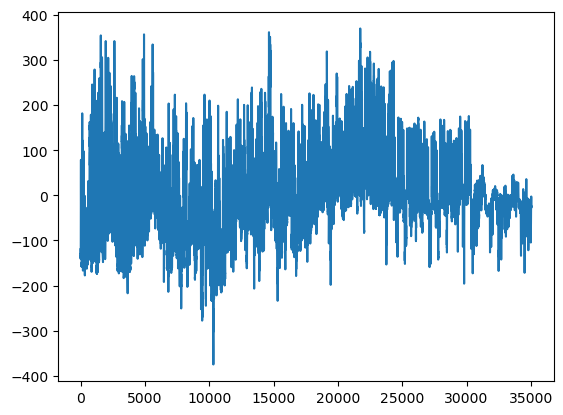

In [90]:
df['production_usage'].plot(color="red")
df['consumption_usage'].plot(alpha=0.5)
plt.show()

df['diff'] = df['consumption_usage'] - df['production_usage']
df['diff'].plot()
plt.show()

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
35035    0.0
35036    0.0
35037    0.0
35038    0.0
35039    0.0
Name: diff, Length: 35040, dtype: float64

In [43]:
# Data Loader Parameters
BATCH_SIZE = 256
BUFFER_SIZE = 1000
TRAIN_SPLIT = 32000

# LSTM Parameters
EVALUATION_INTERVAL = 200
EPOCHS = 4
PATIENCE = 5

features_considered =  [
                    'consumption_usage','production_usage','price', 'isWeekend', 
                    'isHoliday',  'temp', 'wind','day_cos', 'day_sin',
                    'month_cos', 'month_sin'
                    ]
features = df[features_considered]
features.index = df['date']
features.head()

,consumption_usage,production_usage,price,isWeekend,isHoliday,temp,wind,day_cos,day_sin,month_cos,month_sin
date,,,,,,,,,,,
2020-01-01 00:00:00,76.404,2798.32,33.2,0,1,-8.0,3,1.000000,0.000000,0.999963,-0.008601
2020-01-01 00:15:00,72.212,3028.60,33.2,0,1,-8.0,3,1.000000,0.000000,0.999965,-0.008422
2020-01-01 00:30:00,70.992,3004.99,33.2,0,1,-8.0,3,1.000000,0.000000,0.999966,-0.008243
2020-01-01 00:45:00,70.872,2989.17,33.2,0,1,-8.0,3,1.000000,0.000000,0.999967,-0.008064
2020-01-01 01:00:00,80.540,3027.92,30.4,0,1,-8.4,3,0.965926,0.258819,0.999969,-0.007884


In [62]:
dataset = features.values
# data_mean = dataset[:TRAIN_SPLIT].mean()
# data_std = dataset[:TRAIN_SPLIT].std()
# dataset = (dataset-data_mean)/data_std

In [63]:
future_target = 72
past_history = 90
STEP = 6 
x_train_multi, y_train_multi = multivariate_multioutput_data(dataset[:,:2], dataset[:,:2], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_multioutput_data(dataset[:,:2], dataset[:, :2],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

In [64]:
print (x_train_multi.shape,
       y_train_multi.shape,
       x_val_multi.shape,
       y_val_multi.shape,
       'Single window of past history : {}'.format(x_train_multi[0].shape),
       'Target temperature to predict : {}'.format(y_train_multi[0].shape),
       sep='\n')

(31910, 15, 2, 1, 1)
(31910, 72, 2, 1, 1)
(2878, 15, 2, 1, 1)
(2878, 72, 2, 1, 1)
Single window of past history : (15, 2, 1, 1)
Target temperature to predict : (72, 2, 1, 1)


In [65]:
y_train_multi

array([[[[[  66.084 ]],

         [[3204.46  ]]],


        [[[  68.108 ]],

         [[3231.03  ]]],


        [[[  68.928 ]],

         [[3234.39  ]]],


        ...,


        [[[ 265.456 ]],

         [[3192.8924]]],


        [[[ 262.056 ]],

         [[3158.2348]]],


        [[[ 260.788 ]],

         [[3147.07  ]]]],



       [[[[  68.108 ]],

         [[3231.03  ]]],


        [[[  68.928 ]],

         [[3234.39  ]]],


        [[[  67.104 ]],

         [[3176.56  ]]],


        ...,


        [[[ 262.056 ]],

         [[3158.2348]]],


        [[[ 260.788 ]],

         [[3147.07  ]]],


        [[[ 273.768 ]],

         [[3148.74  ]]]],



       [[[[  68.928 ]],

         [[3234.39  ]]],


        [[[  67.104 ]],

         [[3176.56  ]]],


        [[[  65.548 ]],

         [[3152.79  ]]],


        ...,


        [[[ 260.788 ]],

         [[3147.07  ]]],


        [[[ 273.768 ]],

         [[3148.74  ]]],


        [[[ 261.912 ]],

         [[3115.53  ]]]],



       ...,



In [66]:
BATCH_SIZE = 128

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

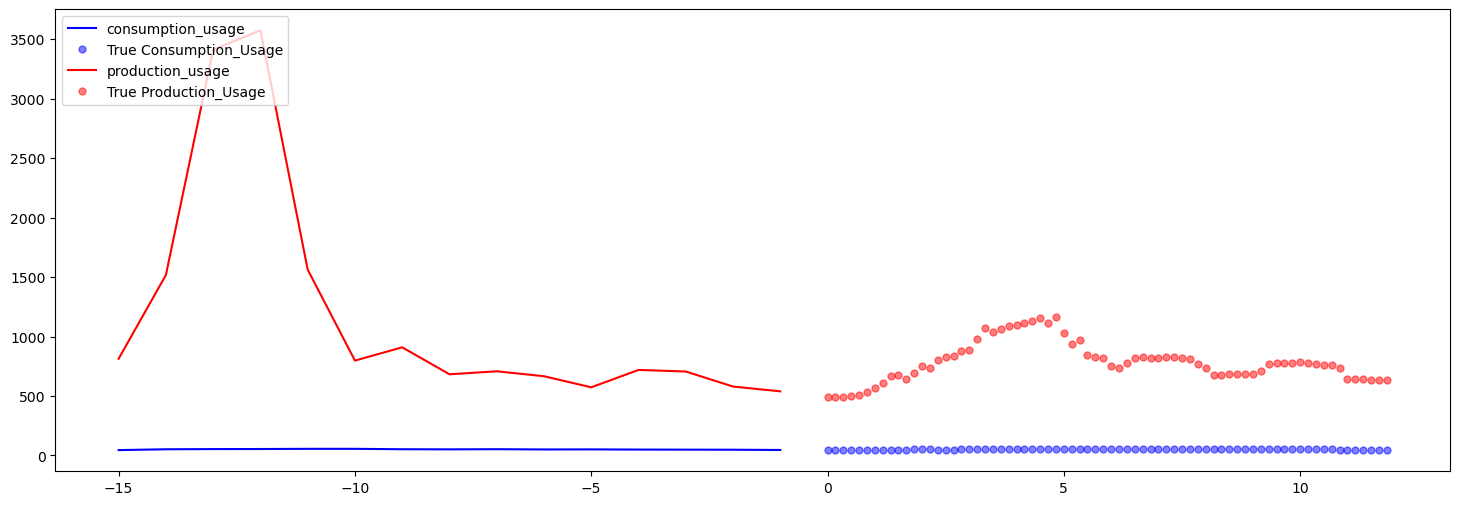

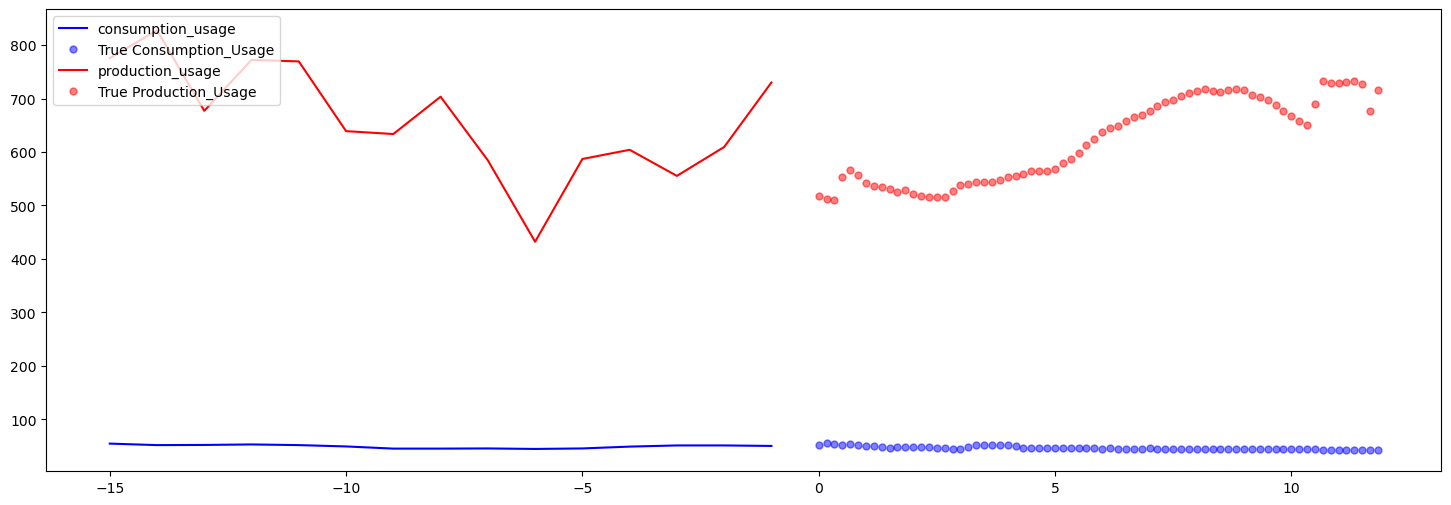

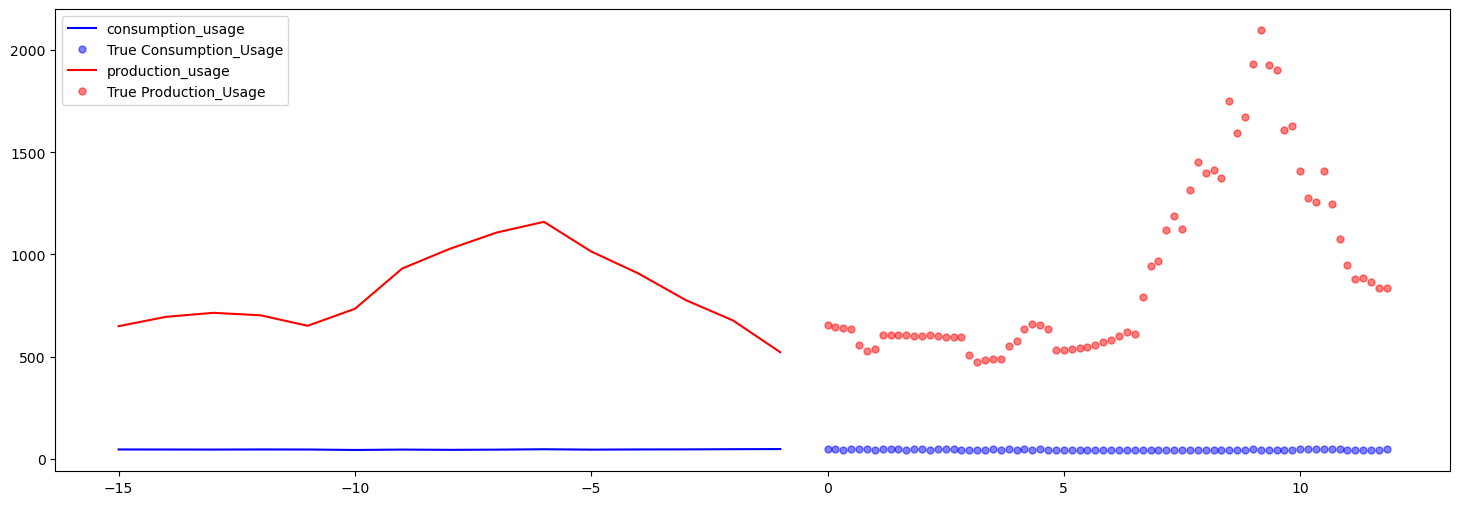

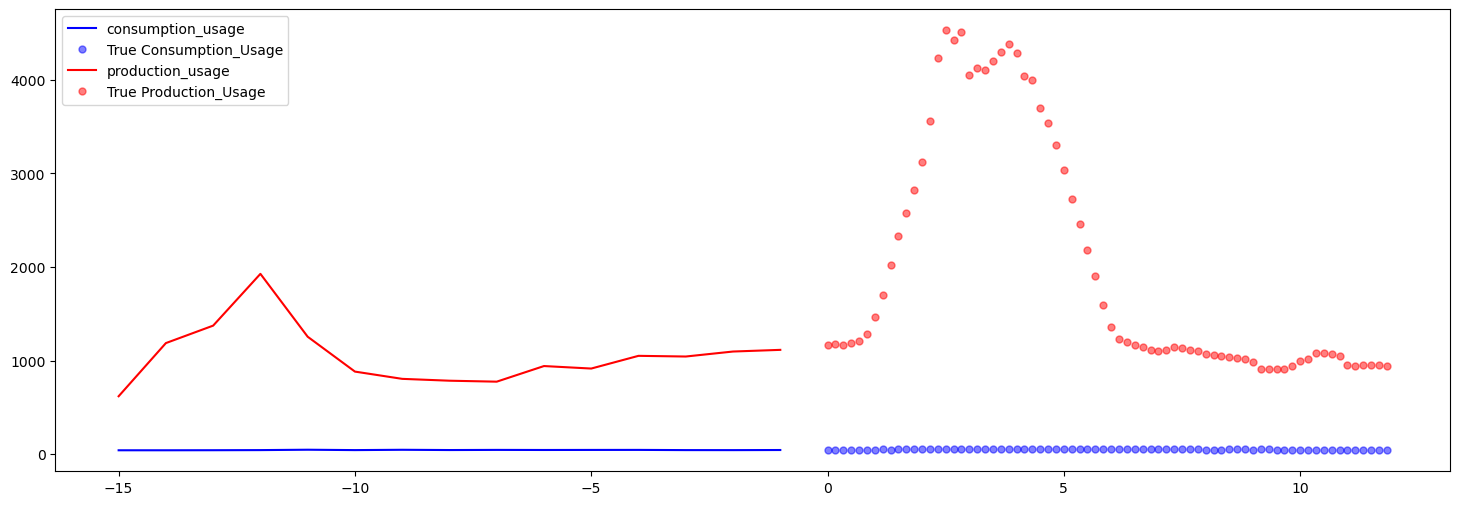

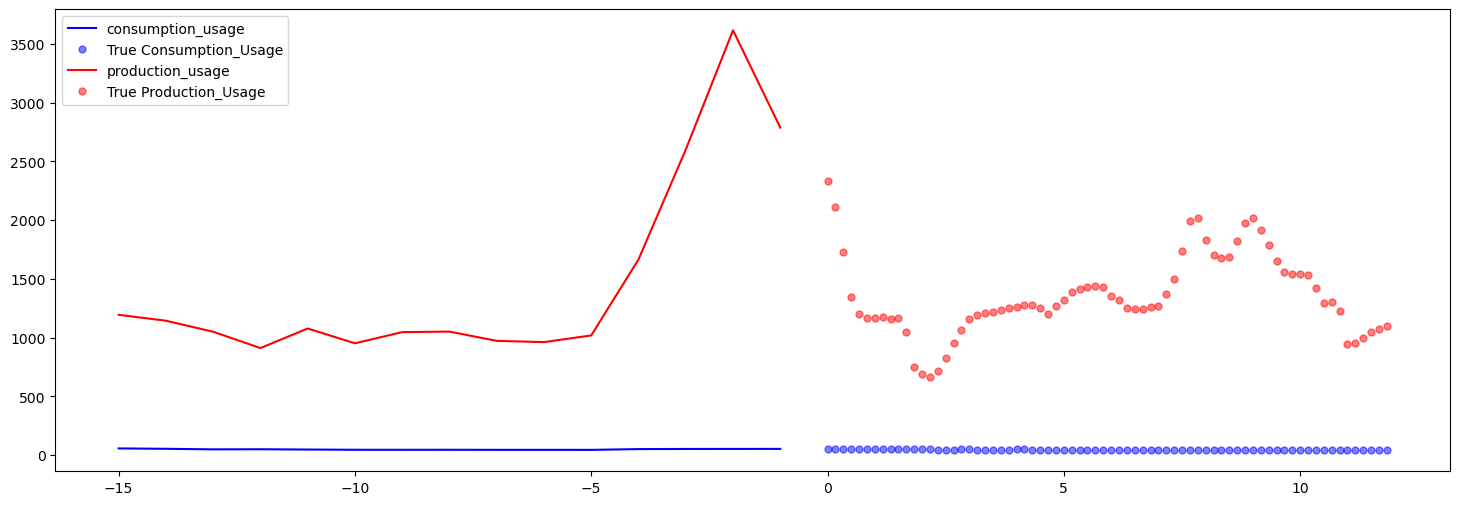

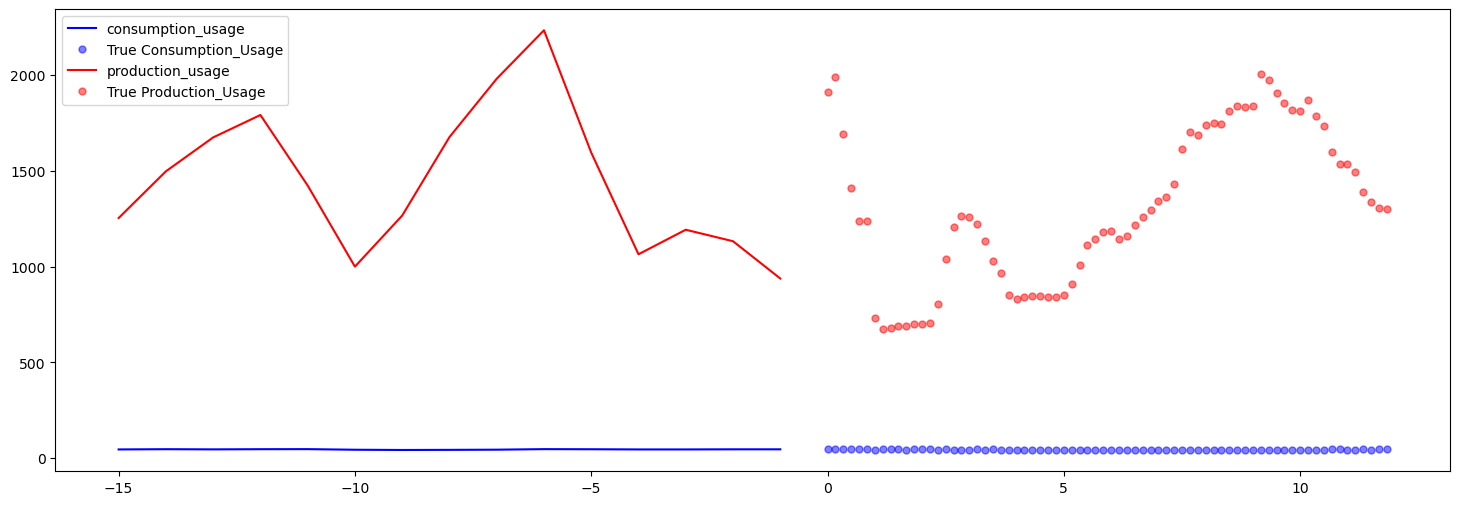

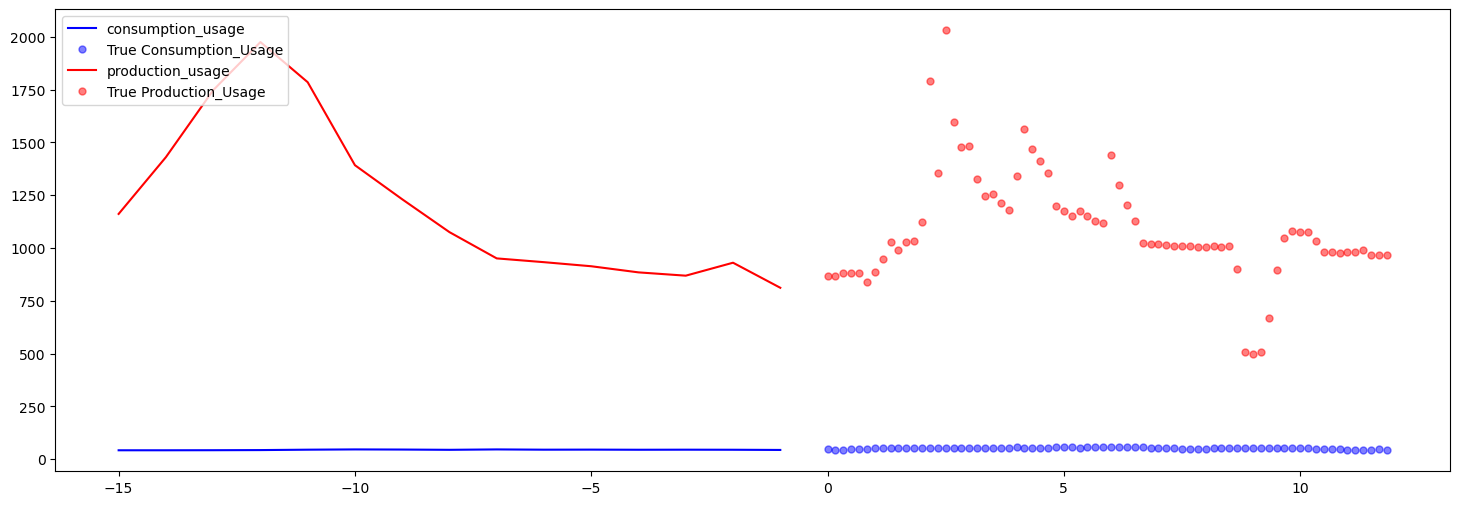

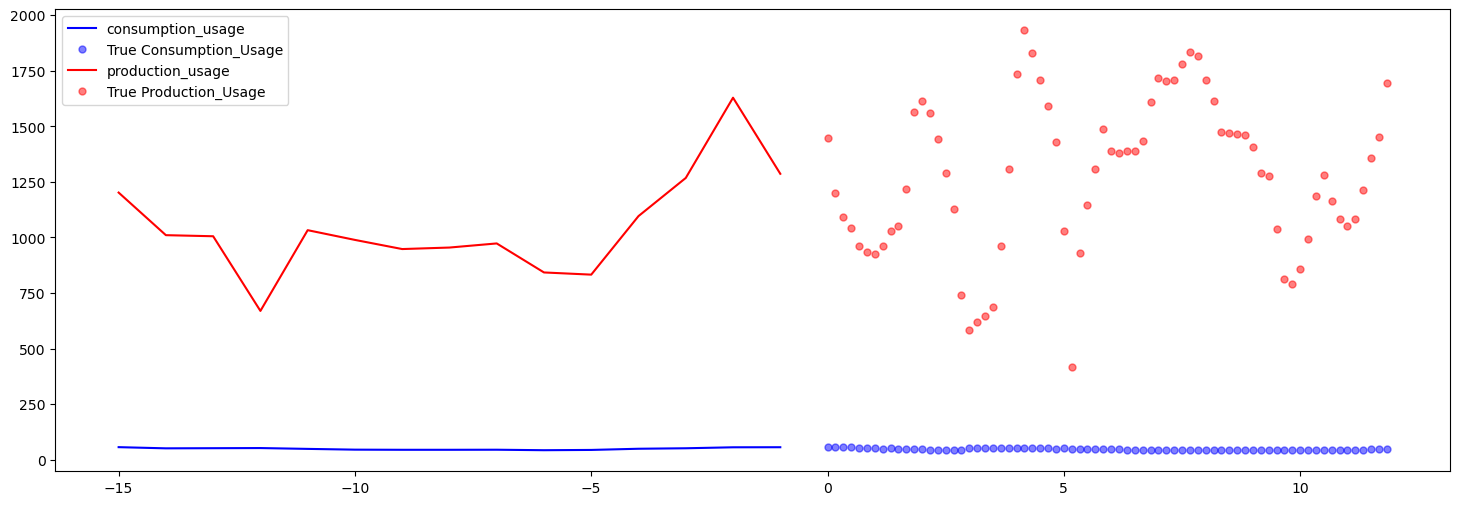

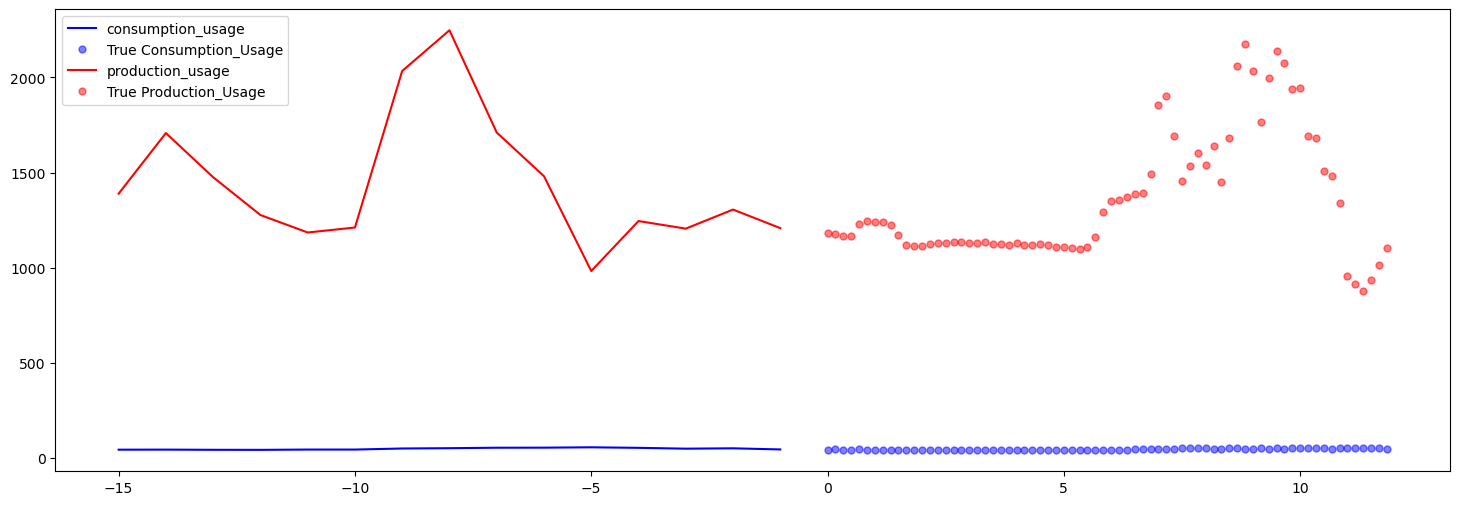

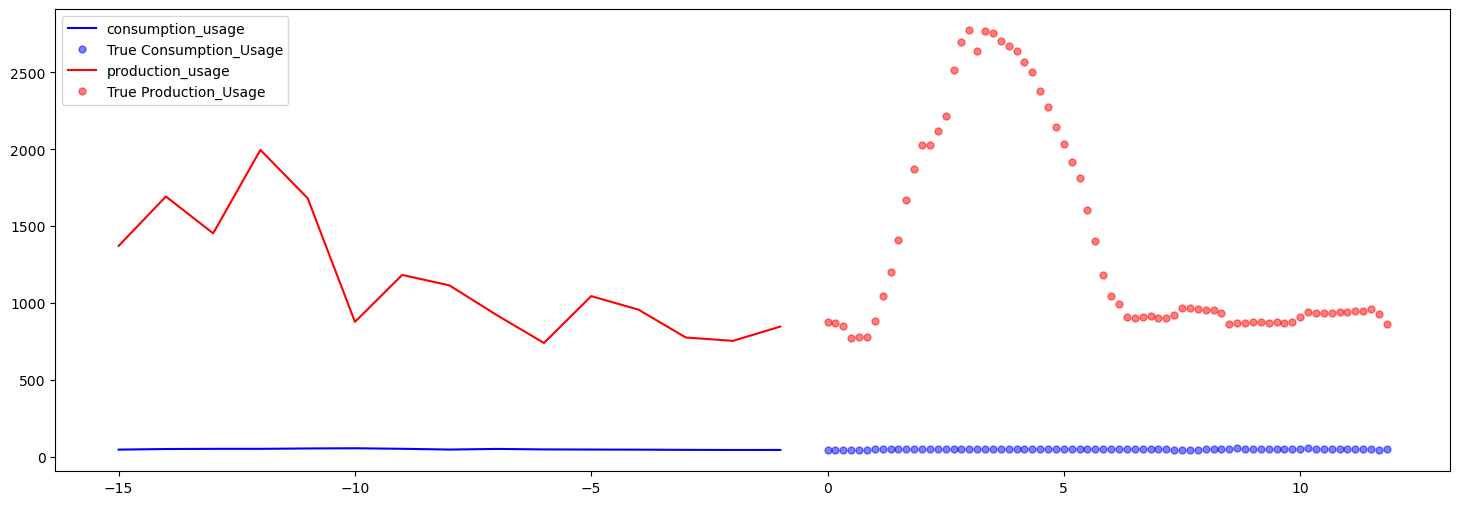

In [67]:
for x, y in val_data_multi.take(10):
    multi_step_output_plot(np.squeeze(x[0]), np.squeeze(y[0]), np.array([0]))